In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture

In [40]:
# load data
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")
test = pd.read_csv("test.csv")
test_X = test.iloc[:,1:]
test_y = test.iloc[:,0]

The idea is as follows. Since we have said that there are no outliers in the traning, it means that we will want to train our model as best as possible, so that the clusters are as clean as possible. One could of course assume that we are doing one large calster, and then when testing everything that would be in a certain distance from it, we would consider outlier. However, I believe you need to make such decisions based on some experimentation. The fact that there are no outlier samples does not mean that we can only highlight one calster. Rather, we expect some small numbers in order not to crumble too much, but not necessarily 1 is the best choice.

We now dump the collection onto the plane with PCA, we will use the silhouette metric. It prefers round clusters. Of course we cannot be sure that the original set contains "round" clusters and depicting it reduced to 2 dimensions does not confirm that it has "convex" clusters, but that's better than nothing

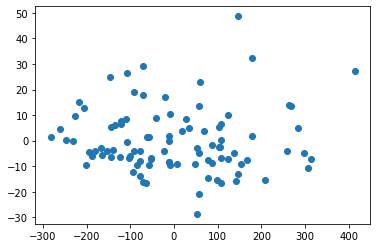

In [3]:
pca = PCA(n_components=2)
pca.fit(train)
pca_train = pca.transform(train)
XY = pd.DataFrame(pca_train)
plt.scatter(XY[0], XY[1])
plt.show()

In [4]:
def chose_components(n, X, score_fun):
    scores = []  
    for i in range(2, n):
        gmm = GMM(n_components = i, covariance_type = 'full')
        labels = gmm.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    plt.plot(range(2, n), scores)
    return scores

[0.29768430900930104,
 0.5626698628047635,
 0.5353149066996757,
 0.48699250950933143,
 0.45445129544917434,
 0.4734087175663116,
 0.4761300274328743,
 0.4080133410849341]

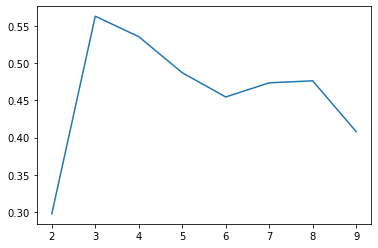

In [5]:
from sklearn.metrics import silhouette_score
chose_components(10, train, silhouette_score)

We can see that the most promising is 3. We will finally figure out what the guess is for `n_components = 1`. But for the moment we are going to stick to the split into 3. Another approach would be to have the validation set along with the classes and correct the number of clusters on it. Since this is not the case, we will use the graphs to find out which probes are outliers

In [32]:
gmm = GMM(n_components = 3, covariance_type = 'full')
gmm.fit(train)

GaussianMixture(n_components=3)

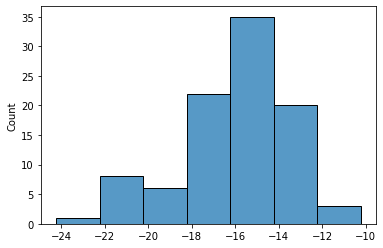

In [33]:
score_tr = gmm.score_samples(train) # Compute the weighted log probabilities for each sample.
sns.histplot(score_tr,binwidth=2)
plt.show()

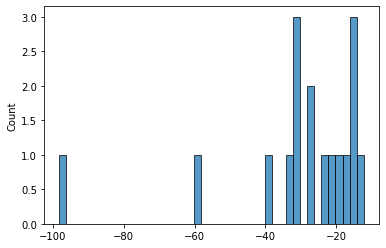

In [34]:
score_val = gmm.score_samples(val) # Compute the weighted log probabilities for each sample.
sns.histplot(score_val,binwidth=2)
plt.show()

We see that it will definitely be something around -40. We can now check how this value translates into the isolation of outliers

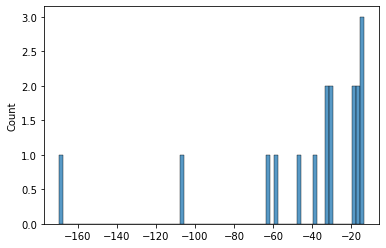

In [41]:
score_test_X = gmm.score_samples(test_X) # Compute the weighted log probabilities for each sample.
sns.histplot(score_test_X,binwidth=2)
plt.show()

Time for our predictions

In [50]:
test_y_hat = (score_test_X < -40).astype(int)

In [53]:
print(classification_report(test_y, test_y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



Well, I must admit that it couldn't be better. The dataset was indeed hard for me to tell if there is overfitting, or maybe even underfitting, because we reject on the basis of one value, which is not complicated. Anyway, we managed to find outliners using this technique and the results are better than good :)